In [5]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import spearmanr as scor

### Informative scores across perturbed pathways

In [6]:
data2 = pd.read_csv('../results/benchmark/z_scores/progeny/single/KEGG_filtered_abs.csv',
                  sep=',', header=0, index_col=0)
data1 = pd.read_csv('../results/benchmark/z_scores/progeny/single/BEST_dorothea_AB_filtered_abs.csv',
                   sep=',', header=0, index_col=0)

In [7]:
data1['Gene set'] = data1.index
data1 = pd.melt(data1, id_vars='Gene set', value_vars=data1.columns[:-1], var_name='Perturbed pathway', 
       value_name='Informative score')
data2['Gene set'] = data2.index
data2 = pd.melt(data2, id_vars='Gene set', value_vars=data2.columns[:-1], var_name='Perturbed pathway', 
       value_name='Informative score')
data1['Database'] = 'DoRothEA'
data2['Database'] = 'KEGG'
data = pd.concat([data1, data2])
data['Informative score'] = data['Informative score'].abs()

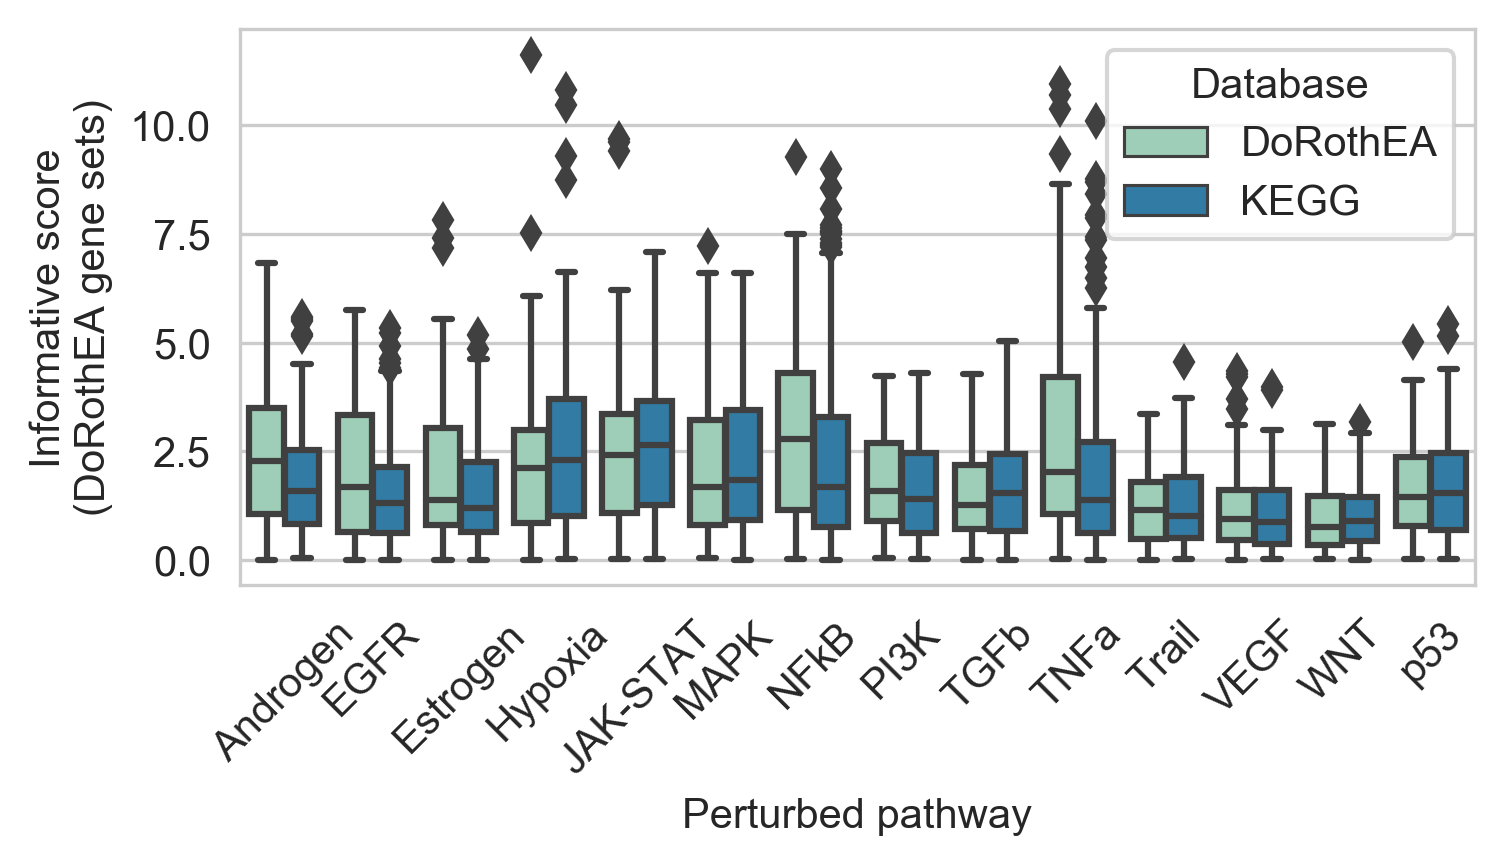

In [8]:
plt.figure(figsize=(5,3), dpi=300)
sns.set_palette('YlGnBu', 2)
sns.boxplot(x=data['Perturbed pathway'], y=data['Informative score'], hue=data['Database'])
plt.ylabel('Informative score\n(DoRothEA gene sets)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/revision/scores_perturbation.png')

In [9]:
data.columns = ['Gene_set', 'Perturbed_pathway','Informative_score', 'Database']

In [10]:
model = smf.ols('Informative_score ~ Database * Perturbed_pathway', data=data).fit()

In [11]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Database,1.0,29.139363,29.139363,13.524107,2.385886e-04
Perturbed_pathway,13.0,1091.223624,83.940279,38.958206,7.821004e-94
Database:Perturbed_pathway,13.0,116.738473,8.979883,4.167726,6.314308e-07
Residual,4032.0,8687.443315,2.154624,NaN,NaN


### TF mutations in GDSC benchmark data

In [12]:
data = pd.read_csv('../results/benchmark/z_scores/gdsc/single/BEST_dorothea_AB_filtered.csv',
                  sep=',', header=0, index_col=0)

In [13]:
mutations = pd.Series(data.columns).apply(lambda x: x.split('_')[0])

In [14]:
tfs = pd.read_csv('../results/genesets/single/csvs/dorothea_ABCDE.csv', sep=',', header=0, index_col=0)

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
len(set(tfs['Set']) & set(mutations))

27

In [16]:
len(mutations)

172

### Similarity between gene sets

In [17]:
from scipy.stats import mannwhitneyu as mwu

In [18]:
def make_similarity_distribution(fname,dname1='BEST_dorothea_AB',metric='jaccard',force_ylim=False):
    similarities=pd.DataFrame(columns=['Database','Similarity','Random'])
    dnames = ['BEST_dorothea_AB', 'KEGG','BIOCARTA','REACTOME','CGP']
    dnames.remove(dname1)
    for dname2 in dnames:
        #readl
        if dname1 < dname2:
            data=pd.read_csv('../results/similarity/%s_filtered_%s_filtered_%s.csv' % (dname1,dname2,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(1).values
        else: 
            data=pd.read_csv('../results/similarity/%s_filtered_%s_filtered_%s.csv' % (dname2,dname1,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(0).values
        max_sim1=pd.DataFrame(index=range(len(data)),columns=similarities.columns)
        max_sim1['Database']=dname2
        max_sim1['Similarity']=data
        max_sim1['Random']='Actual gene set'
        similarities=pd.concat([similarities,max_sim1])
        #random
        if dname1 < dname2:
            data=pd.read_csv('../results/similarity/%s_random_dist_0_%s_random_dist_0_%s.csv' % (dname1,dname2,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(1).values
        else:
            data=pd.read_csv('../results/similarity/%s_random_dist_0_%s_random_dist_0_%s.csv' % (dname2,dname1,metric),
                             sep=',',header=0,index_col=0)
            data=data.max(0).values
        max_sim2=pd.DataFrame(index=range(len(data)),columns=similarities.columns)
        max_sim2['Database']=dname2
        max_sim2['Similarity']=data
        max_sim2['Random']='Random gene set'
        similarities=pd.concat([similarities,max_sim2])

        print(dname1,dname2,mwu(max_sim1['Similarity'],max_sim2['Similarity']))
    sns.set_palette('YlGnBu',2)
    plt.figure(figsize=(4,3),dpi=300)
    similarities.columns = ['Database', 'Similarity', 'Gene set']
    similarities.index = range(len(similarities))
    fil = similarities['Database']=='BEST_dorothea_AB'
    similarities.loc[similarities.index[fil], 'Database'] = 'DoRothEA'
    sns.boxplot(x='Database',y='Similarity',hue='Gene set',data=similarities)
    if metric=='jaccard':
        plt.ylabel('Jaccard index', size=15)
    else:
        plt.ylabel('Overlap coefficient', size=15)
    plt.xlabel('Database', size=15)
    if force_ylim:
        plt.ylim(0,1.0)
    plt.tight_layout()
    if fname:
        plt.savefig('../figures/raw/'+fname)

KEGG BEST_dorothea_AB MannwhitneyuResult(statistic=12975.0, pvalue=0.00031249721237381516)
KEGG BIOCARTA MannwhitneyuResult(statistic=11920.0, pvalue=3.7231536260677854e-06)
KEGG REACTOME MannwhitneyuResult(statistic=3.0, pvalue=4.1006882529236803e-61)
KEGG CGP MannwhitneyuResult(statistic=3160.5, pvalue=1.5150109049810776e-40)


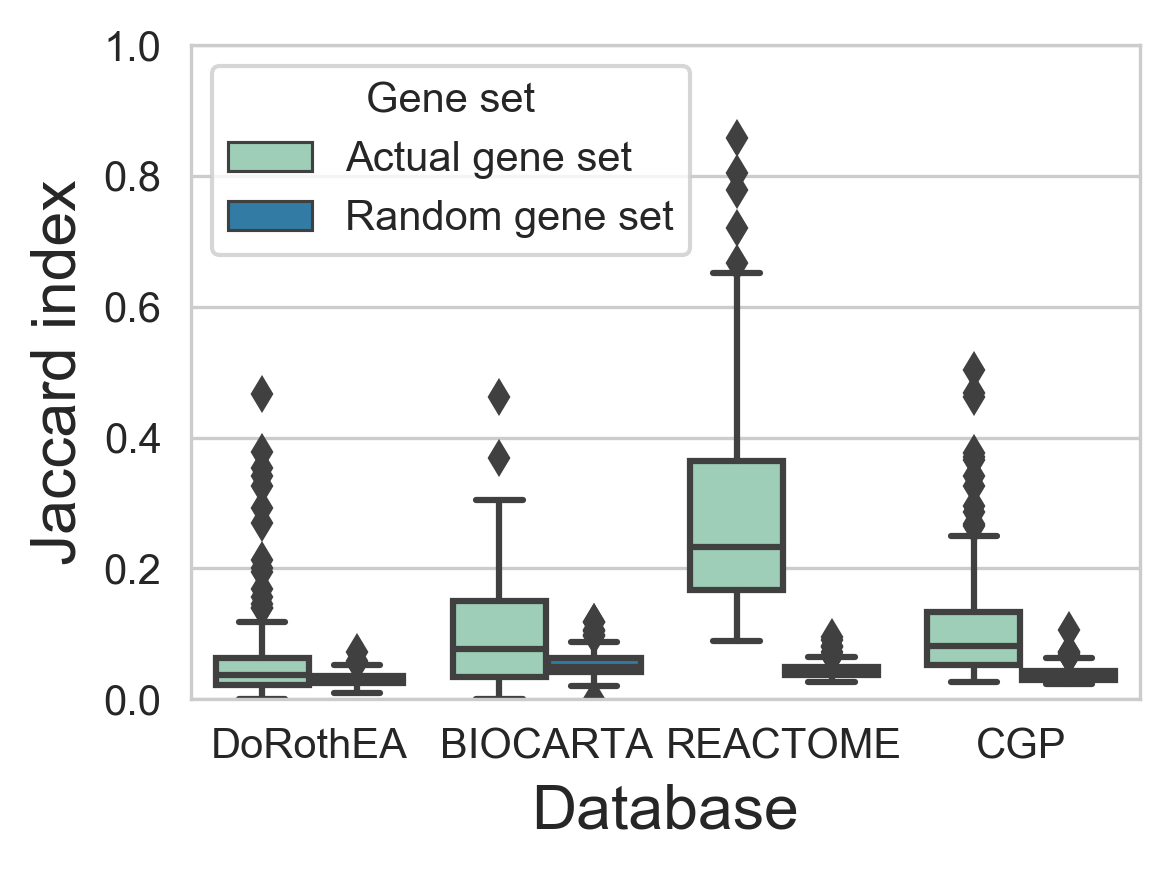

In [19]:
make_similarity_distribution('SFig2E.pdf', 'KEGG', 'jaccard', True)

KEGG BEST_dorothea_AB MannwhitneyuResult(statistic=13654.0, pvalue=0.003056793735060593)
KEGG BIOCARTA MannwhitneyuResult(statistic=13189.5, pvalue=0.0006666455955803385)
KEGG REACTOME MannwhitneyuResult(statistic=398.0, pvalue=6.384767237248737e-59)
KEGG CGP MannwhitneyuResult(statistic=5465.0, pvalue=1.7901678160068335e-29)


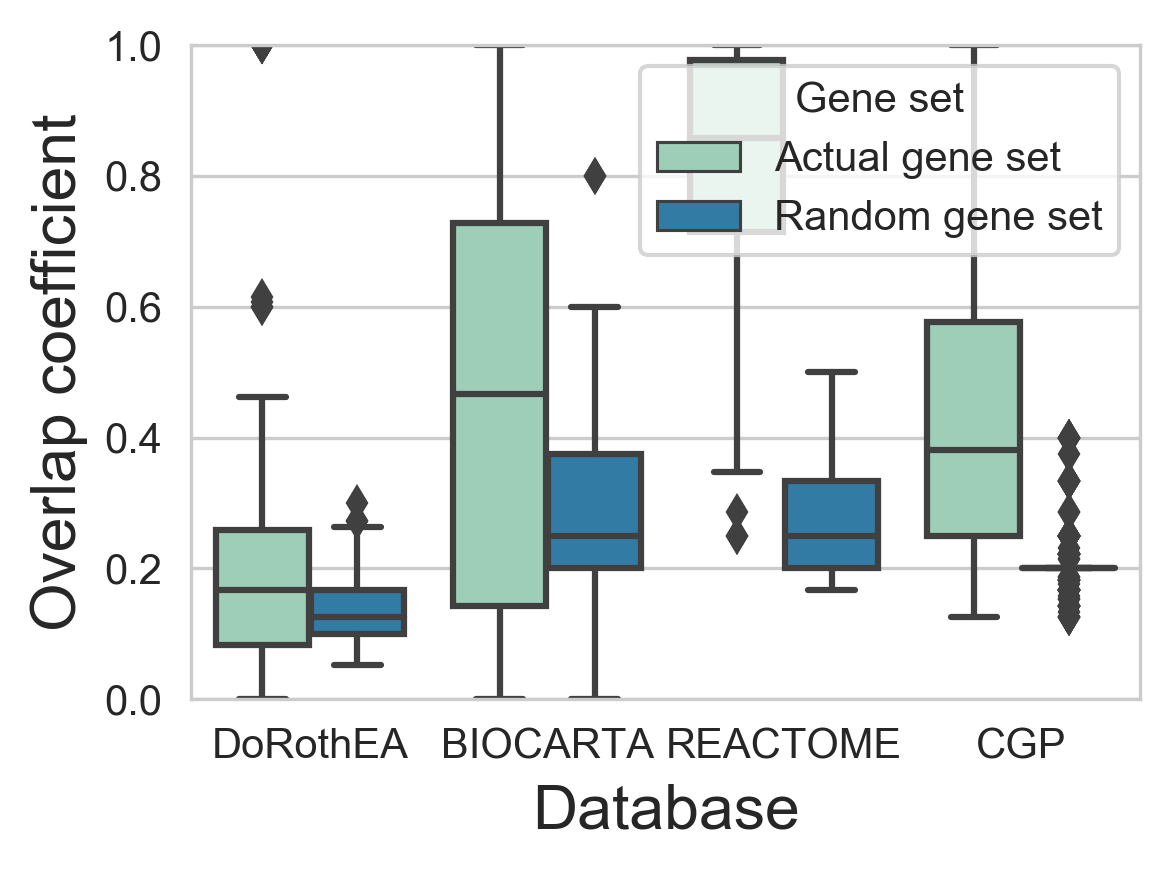

In [20]:
make_similarity_distribution('SFig2F.pdf', 'KEGG', 'overlap', True)

### Plot with regression line

In [21]:
def plot_correaltions_all(dname1,name1,abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    sns.set_palette('GnBu',6)
    dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
    dnames.sort(reverse=True)
    activities=pd.Series()
    similiarities=pd.Series()
    sizes=pd.Series()
    dset_names=[]
    for dname in dnames:
        activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                         sep=',',header=0,index_col=0).abs().max(1)
        if dname1<dname:
            fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
        else:
            fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
        similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
        size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                         header=0,index_col=0)
        size=size['Set'].value_counts()
        if dname1<dname:
            similarity=similarity.max(0)
        else:
            similarity=similarity.max(1)
        sets=list(set(activity.index)&set(similarity.index)) 
        activities=pd.concat([activities,activity[sets]])   
        similiarities=pd.concat([similiarities,similarity[sets]])
        sizes=pd.concat([sizes,size[sets]])
        if 'dorothea' not in dname:
            dset_names+=[dname]*len(sets)
        elif dname == 'BEST_dorothea_AB':
            dset_names += ['High confidence\nDoRothEA']*len(sets)
        else:
            dset_names += ['Low confidence\nDoRothEA']*len(sets)
    plt.figure(figsize=(4,3),dpi=300)
    sns.scatterplot(similiarities,activities,hue=dset_names, alpha=0.7)
    sns.regplot(similiarities, activities, marker='', color='k')
    if sim_type=='jaccard':
        sim_label='Jaccard index'
    else:
        sim_label='Overlap coefficient'
    plt.xlabel('Similarity to '+name1+'\n('+sim_label+')',size=13)
    plt.ylabel('Informative score',size=13)
    plt.legend(fontsize=7)
    plt.tight_layout()
    print(scor(activities,similiarities))

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


SpearmanrResult(correlation=0.23584305188949806, pvalue=3.7189093459986374e-65)


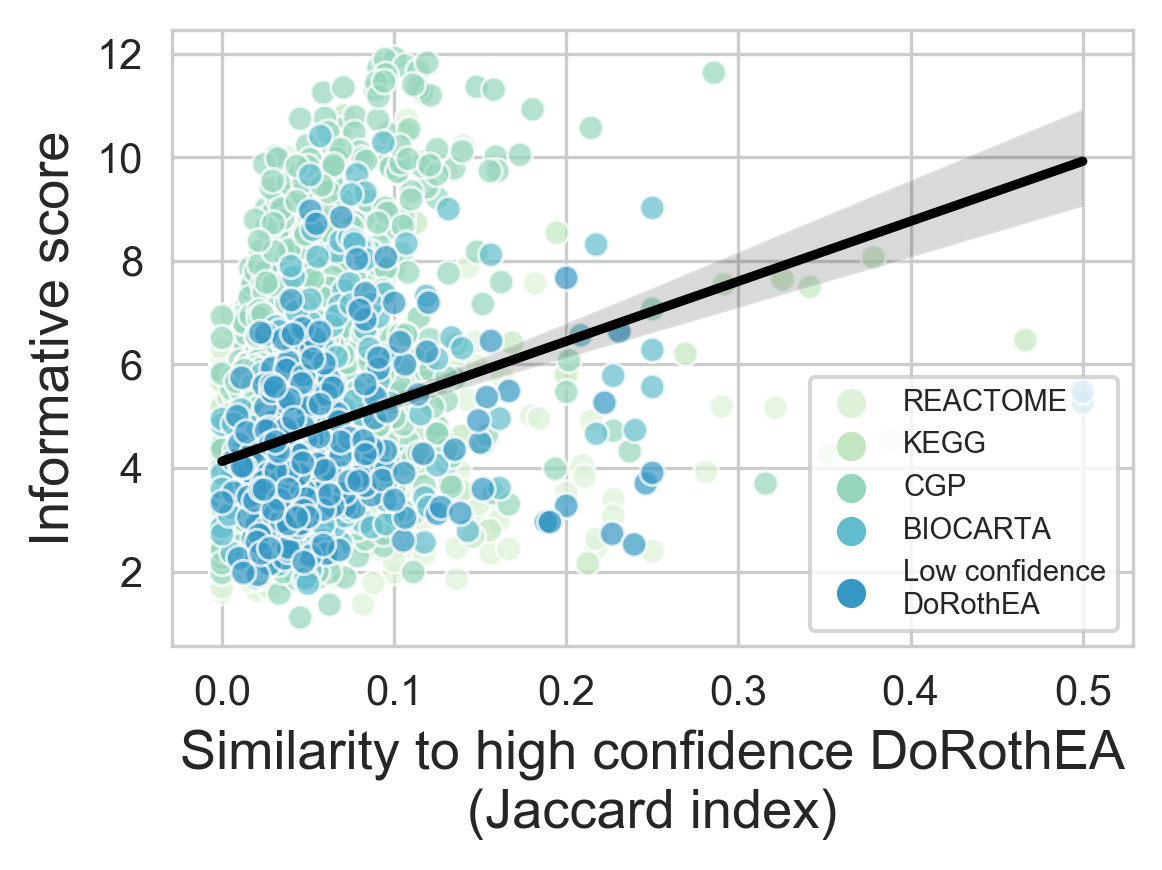

In [22]:
plot_correaltions_all('BEST_dorothea_AB','high confidence DoRothEA','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/revision/regression.png')

### Random gene sets

In [23]:
def calculate_maximal_infromative_statistics(bmark='progeny',abs_type='_abs', rtype='dist'):
    databases=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
    results=pd.DataFrame(columns=['score','database','random','bmark','abs_type','size'])
    for dset in databases:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bmark,dset,abs_type),
                         sep=',',header=0,index_col=0).max(1)
        size = pd.read_csv('../results/genesets/single/csvs/%s_filtered.csv' % dset, 
                 sep=',', header=0, index_col=0)['Set'].value_counts()
        size = size[data.index]
        results_temp=pd.DataFrame(index=range(len(data)),columns=results.columns)
        results_temp['score']=data.values
        results_temp['database']=dset
        results_temp['random']=False
        results_temp['bmark'] = bmark
        results_temp['abs_type'] = abs_type
        results_temp['size'] = size.values
        results=pd.concat([results,results_temp])
        results.index=range(len(results))

        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_random_%s_0%s.csv' % (bmark,dset,
                                                                                           rtype,abs_type),
                         sep=',',header=0,index_col=0).max(1)
        size = pd.read_csv('../results/genesets/single/csvs/%s_random_%s_0.csv' % (dset, rtype), 
                 sep=',', header=0, index_col=0)['Set'].value_counts()
        size = size[data.index]
        results_temp=pd.DataFrame(index=range(len(data)),columns=results.columns)
        results_temp['score']=data.values
        results_temp['database']=dset
        results_temp['random']=True
        results_temp['bmark'] = bmark
        results_temp['abs_type'] = abs_type
        results_temp['size'] = size.values
        results=pd.concat([results,results_temp])
        results.index=range(len(results))
    return results

In [24]:
data = calculate_maximal_infromative_statistics(bmark='progeny',abs_type='_abs', rtype='uniform')
data = data.sort_values('database', ascending=False)
data = data[data['random'] == True]

SpearmanrResult(correlation=-0.02435383408630305, pvalue=0.07972261569626109)


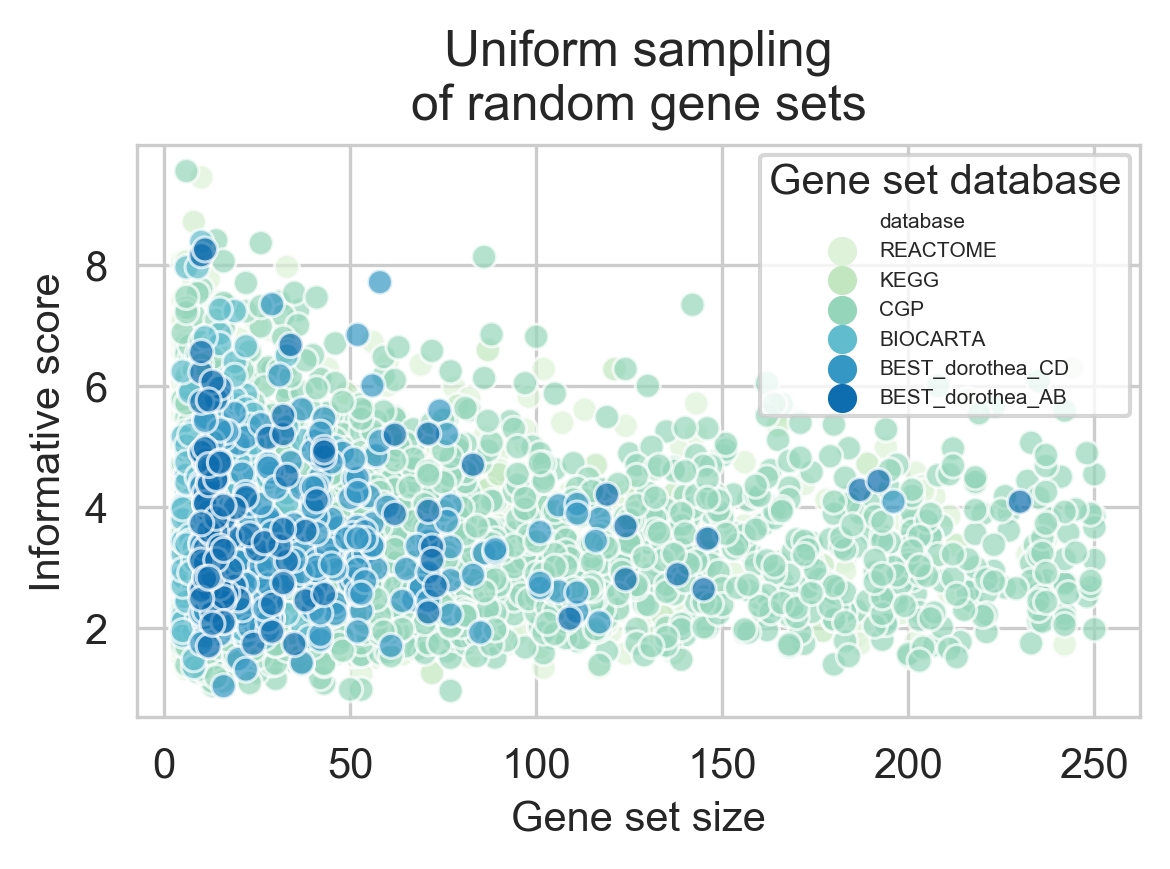

In [25]:
plt.figure(figsize=(4,3),dpi=300)
sns.set_palette('GnBu',6)
sns.scatterplot(data['size'], data['score'], hue=data['database'], alpha=0.7)
plt.legend(title='Gene set database', fontsize=5)
plt.tight_layout()
plt.xlabel('Gene set size')
plt.ylabel('Informative score')
plt.title('Uniform sampling\nof random gene sets')
plt.tight_layout()
print(scor(data['size'], data['score']))
plt.savefig('../figures/revision/unifrom.png')

In [26]:
data = calculate_maximal_infromative_statistics(bmark='progeny',abs_type='_abs', rtype='dist')
data = data.sort_values('database', ascending=False)
data = data[data['random'] == True]

SpearmanrResult(correlation=0.1396659934167853, pvalue=4.7042075793436444e-24)


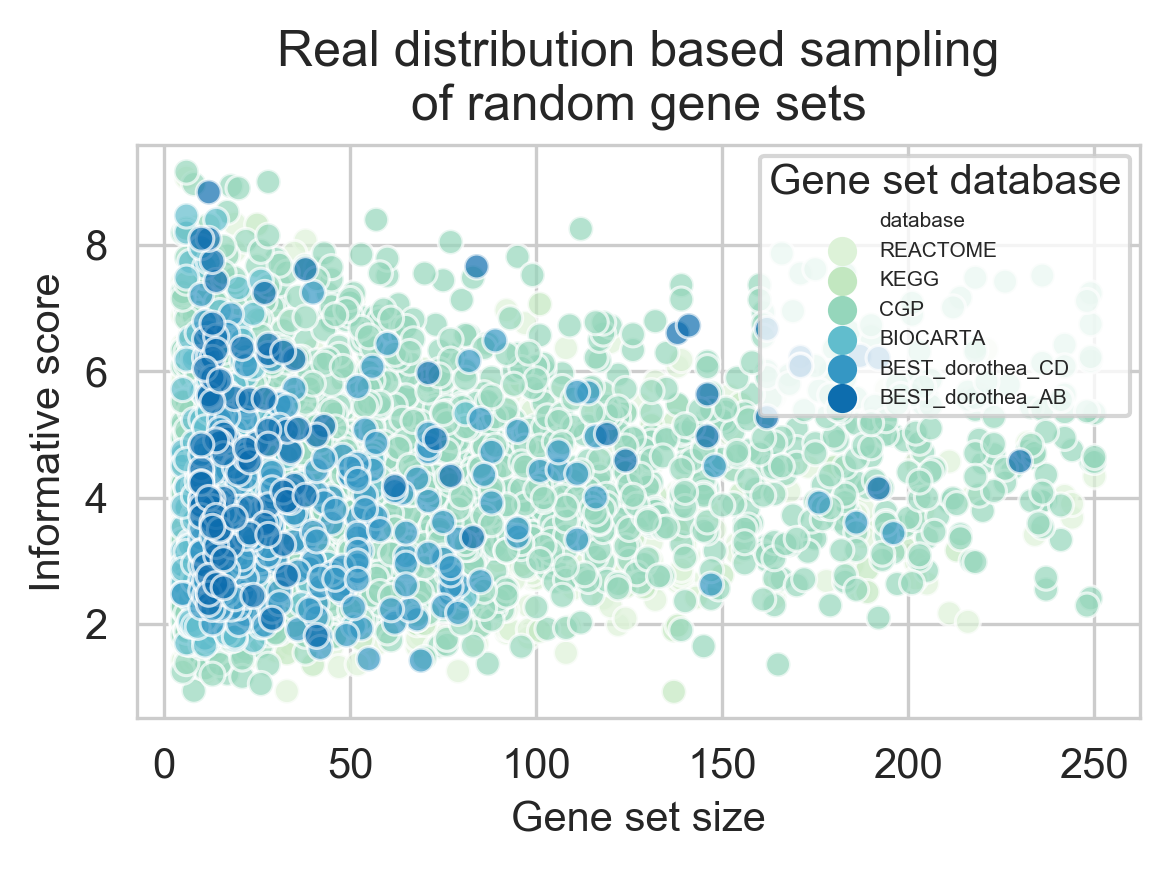

In [27]:
plt.figure(figsize=(4,3),dpi=300)
sns.set_palette('GnBu',6)
sns.scatterplot(data['size'], data['score'], hue=data['database'], alpha=0.7)
plt.legend(title='Gene set database', fontsize=5)
plt.tight_layout()
plt.xlabel('Gene set size')
plt.ylabel('Informative score')
plt.title('Real distribution based sampling\nof random gene sets')
plt.tight_layout()
print(scor(data['size'], data['score']))
plt.savefig('../figures/revision/distribution.png')